In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones_dendro_dt_0.6/"
# DONOR = 0
# dendroThresh=0.6

#clones_meta = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'
#clones_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
#clone_sizes_in_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1/clone_sizes.csv"
INDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2//data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
OUTDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic"
DONOR = 0


# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# DONOR = 1
dendroThresh = "dynamic" #0.6

verbose=False

mt_ref="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [3]:
import src.utils.variant_utils as vu
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACTCGCATTAACGC-1_Flt3l,0_0,0,Flt3l
1,AAACTGCCATGTGGGA-1_Flt3l,0_0,0,Flt3l
2,AAACTGCTCTCGCGGA-1_Flt3l,0_0,0,Flt3l
3,AAAGATGCATCCTGGG-1_Flt3l,0_0,0,Flt3l
4,AAAGATGTCAATTGGC-1_Flt3l,0_0,0,Flt3l
...,...,...,...,...
12688,GCACGCATCGTGGAAG-1_Input,1_32,1,Input
12689,GCTCACTGTCAGAAGC-1_Input,1_32,1,Input
12690,GCTGAGCGTCATAAGA-1_Input,1_32,1,Input
12691,GTTATGGGTCAGTGCC-1_Input,1_32,1,Input


In [7]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,831,0
0_1,431,0
0_10,269,0
0_11,249,0
0_12,248,0
...,...,...
1_5,286,1
1_6,273,1
1_7,239,1


In [8]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [9]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [10]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [11]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

### Calculate clone-barcode mean

In [12]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]

# Remove clones that have all 0
# print('mean_af shape', mean_af.shape)
# mean_af = mean_af.loc[~((mean_af==0).all(axis=1))]
# curr_clones = curr_clones.loc[mean_af.index]
# print('mean_af shape after rm 0', mean_af.shape)

mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

#mean_dp = mean_dp.reset_index(drop=True)
anno_dp = mean_dp.reset_index()[["lineage"]]
na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
mean_af  

Variant,4769G,11453A,14233G,709A,14905A,13188T,189G,15452A,10463C,1438G,...,14766T,16296T,16129A,10589A,8292A,3847C,10397G,3244A,10559G,11812G
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,0.988357,0.003007,0.002851,0.012757,0.010775,0.985082,0.001043,0.002437,0.011592,0.990914,...,0.996156,0.000845,0.009419,0.976334,0.985987,0.980205,0.978375,0.003614,0.012009,0.014392
0_1,0.981297,0.001938,0.004382,0.022807,0.005842,0.979222,0.001031,0.003840,0.020958,0.990421,...,0.994808,0.000783,0.009797,0.948715,0.972035,0.979050,0.984121,0.007831,0.034973,0.005257
0_10,0.999456,0.000840,0.000361,0.001176,0.000400,0.996996,0.002931,0.000186,0.001189,0.999880,...,0.999540,0.000236,0.003864,0.996430,0.996768,0.992752,0.997608,0.003482,0.000812,0.000528
0_11,0.998839,0.000000,0.000705,0.000859,0.000873,0.995906,0.000000,0.000674,0.000444,0.999811,...,0.999719,0.000418,0.001339,0.990178,0.995779,0.997655,0.997039,0.003038,0.000382,0.000992
0_12,0.998723,0.001116,0.000111,0.001243,0.000674,0.995733,0.004003,0.000227,0.000457,0.995831,...,0.995617,0.000000,0.004032,0.997284,0.994769,0.994977,0.995490,0.007675,0.000686,0.000125
0_13,0.995315,0.000775,0.005918,0.007588,0.004301,0.983792,0.004200,0.003998,0.003949,0.995677,...,0.999298,0.001584,0.003165,0.988275,0.995375,0.984810,0.987627,0.003799,0.004991,0.002870
0_14,0.999758,0.002766,0.000811,0.001069,0.000551,0.995188,0.000143,0.000862,0.001286,0.997873,...,0.999752,0.000395,0.006689,0.974301,0.991607,0.995424,0.993082,0.003418,0.001683,0.000944
0_15,0.999507,0.000129,0.003876,0.004255,0.039366,0.987743,0.004040,0.001761,0.001875,0.994591,...,0.999879,0.000000,0.001320,0.986561,0.983491,0.991719,0.977635,0.011884,0.002965,0.039983
0_16,0.994216,0.000489,0.001565,0.002227,0.002310,0.994302,0.000978,0.000791,0.001122,0.994159,...,0.994230,0.000000,0.000000,0.997219,0.995948,0.997214,0.998451,0.001210,0.002103,0.003190


In [13]:
# Get variant types
variants_df = vu.add_ref_to_variants(variants=mean_af.columns.values,
                                     mt_df=vu.load_mt_ref(mt_ref))

variants_df = vu.type_of_variants(variants_df, to_preproc=False)

In [14]:
# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

### Cluster to get dendro results

In [15]:
mean_af

Variant,4769G,11453A,14233G,709A,14905A,13188T,189G,15452A,10463C,1438G,...,14766T,16296T,16129A,10589A,8292A,3847C,10397G,3244A,10559G,11812G
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,0.988357,0.003007,0.002851,0.012757,0.010775,0.985082,0.001043,0.002437,0.011592,0.990914,...,0.996156,0.000845,0.009419,0.976334,0.985987,0.980205,0.978375,0.003614,0.012009,0.014392
0_1,0.981297,0.001938,0.004382,0.022807,0.005842,0.979222,0.001031,0.003840,0.020958,0.990421,...,0.994808,0.000783,0.009797,0.948715,0.972035,0.979050,0.984121,0.007831,0.034973,0.005257
0_10,0.999456,0.000840,0.000361,0.001176,0.000400,0.996996,0.002931,0.000186,0.001189,0.999880,...,0.999540,0.000236,0.003864,0.996430,0.996768,0.992752,0.997608,0.003482,0.000812,0.000528
0_11,0.998839,0.000000,0.000705,0.000859,0.000873,0.995906,0.000000,0.000674,0.000444,0.999811,...,0.999719,0.000418,0.001339,0.990178,0.995779,0.997655,0.997039,0.003038,0.000382,0.000992
0_12,0.998723,0.001116,0.000111,0.001243,0.000674,0.995733,0.004003,0.000227,0.000457,0.995831,...,0.995617,0.000000,0.004032,0.997284,0.994769,0.994977,0.995490,0.007675,0.000686,0.000125
0_13,0.995315,0.000775,0.005918,0.007588,0.004301,0.983792,0.004200,0.003998,0.003949,0.995677,...,0.999298,0.001584,0.003165,0.988275,0.995375,0.984810,0.987627,0.003799,0.004991,0.002870
0_14,0.999758,0.002766,0.000811,0.001069,0.000551,0.995188,0.000143,0.000862,0.001286,0.997873,...,0.999752,0.000395,0.006689,0.974301,0.991607,0.995424,0.993082,0.003418,0.001683,0.000944
0_15,0.999507,0.000129,0.003876,0.004255,0.039366,0.987743,0.004040,0.001761,0.001875,0.994591,...,0.999879,0.000000,0.001320,0.986561,0.983491,0.991719,0.977635,0.011884,0.002965,0.039983
0_16,0.994216,0.000489,0.001565,0.002227,0.002310,0.994302,0.000978,0.000791,0.001122,0.994159,...,0.994230,0.000000,0.000000,0.997219,0.995948,0.997214,0.998451,0.001210,0.002103,0.003190


In [16]:
if mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 :
    print('no clustering needed only one var')
else:
    g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]
    curr_clones = curr_clones.iloc[inds]
    plt.close(g.fig)

### Cluster and calculate proper size

In [17]:
%matplotlib inline
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):

    if dendroThresh == "dynamic":
        clusters, link = dc.run_dynamic_hyper(np.sqrt(mean_af))
        #clusters, link = dc.run_dynamic(mean_af, metric='euclidean', method="average", minClusterSize=1)
        curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)

    else:
        den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)

        if verbose:
            print('icoord and color list')
            print(len(den["icoord"]))
            print(len(den["color_list"]))
            print('leaves leaves color and mean_af shape')
            print(len(den["leaves"]))
            print(len(den["leaves_color_list"]))
            print(mean_af.shape)
        # cluster_classes = dc.get_cluster_classes(den)
        curr_clones = dc.add_cluster_labels(den,curr_clones)
        curr_clones

    size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

    curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
    curr_clones = curr_clones.loc[mean_af.index]

    # with open(out_f + ".dendrogram_pvals.txt", "w") as f:
    #     #for l in size_pvals:
    #     f.write("\n".join(size_pvals))

    curr_clones

else:
    with open(out_f+".dendrogram_pvals.txt", "w") as f:
        f.write("no cells")
    

distances
[0.01489 0.01718 0.01724 0.00260 0.00554 0.00211 0.01541 0.00220 0.02341
 0.00433 0.01698 0.00252 0.01759 0.02513 0.01601 0.01838 0.01575 0.01664
 0.01726 0.00237 0.00235 0.01568 0.00286 0.00602 0.00232 0.01503 0.01726
 0.01537 0.01756 0.01651 0.00200 0.02515 0.00398 0.00434 0.01909 0.00413
 0.01309 0.00289 0.01774 0.01574 0.01806 0.00356 0.00760 0.00332 0.01518
 0.00331 0.00737 0.00363 0.00321 0.00386 0.01730 0.01759 0.00425 0.01985
 0.02033 0.01821 0.03059 0.00406 0.00363 0.00446 0.00331 0.01929 0.01642
 0.00022 0.01621 0.00388 0.01074 0.00232 0.01632 0.01539 0.01851 0.00210
 0.00743 0.00272 0.01498 0.00218 0.00965 0.00264 0.00285 0.00331 0.01751
 0.01718 0.00344 0.01622 0.02437 0.01773 0.03020 0.00041 0.00760 0.00030
 0.00134 0.02195 0.01915 0.01613 0.00390 0.01067 0.00238 0.01606 0.01541
 0.01841 0.00204 0.00741 0.00282 0.01610 0.00231 0.00960 0.00265 0.00288
 0.00304 0.01750 0.01698 0.00341 0.01615 0.02400 0.01746 0.03032 0.00027
 0.00772 0.00034 0.00142 0.02177 0.01841 

## Group clones using dendrogram and run stats on size differences in the groups

### Run ranksums on clone size btwn debdrogram clusters

In [18]:
# size_pvals = []
# for pair in combinations(curr_clones["den_clust"].unique(),2):
#     print(pair)
#     stat, p_val = scipy.stats.ranksums(curr_clones.loc[curr_clones["den_clust"]==pair[0], "size"].values, 
#                          y=curr_clones.loc[curr_clones["den_clust"]==pair[1], "size"].values, 
#                          alternative='two-sided')

#     size_pvals.append(f"{pair[0]}, {pair[1]}, {str(p_val)}")
    


## Plot with dendro clusters

In [19]:
conditions = cells_meta["condition"].unique()

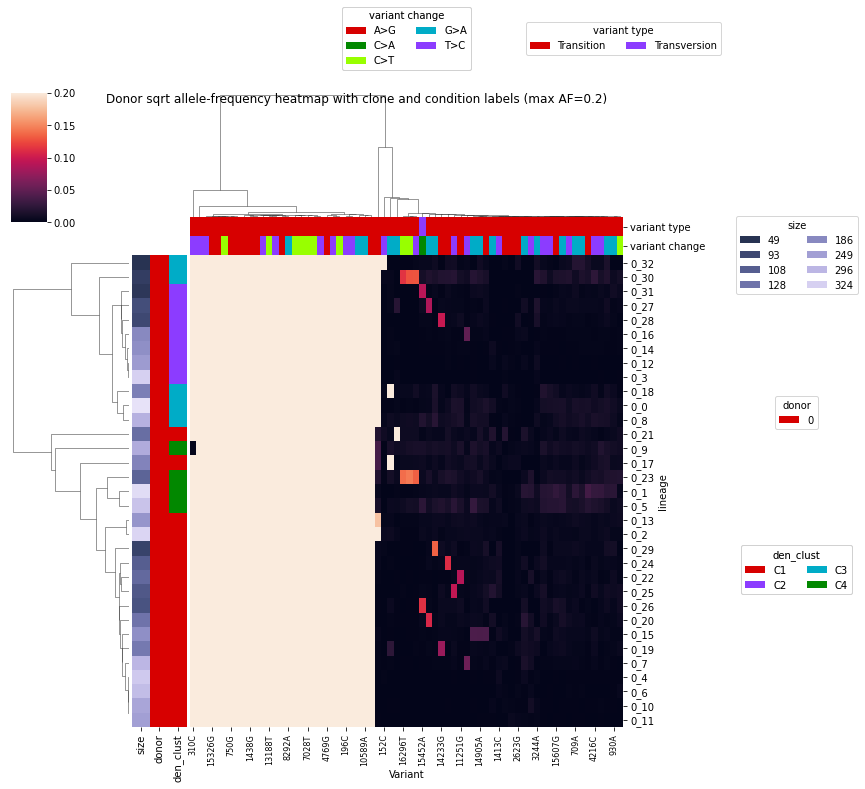

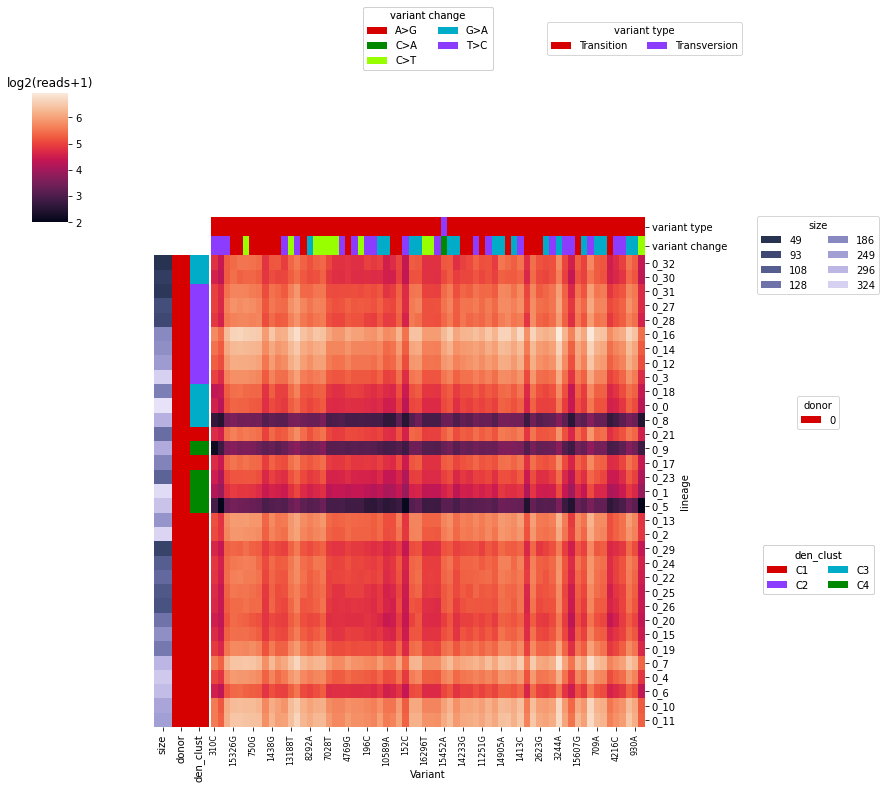

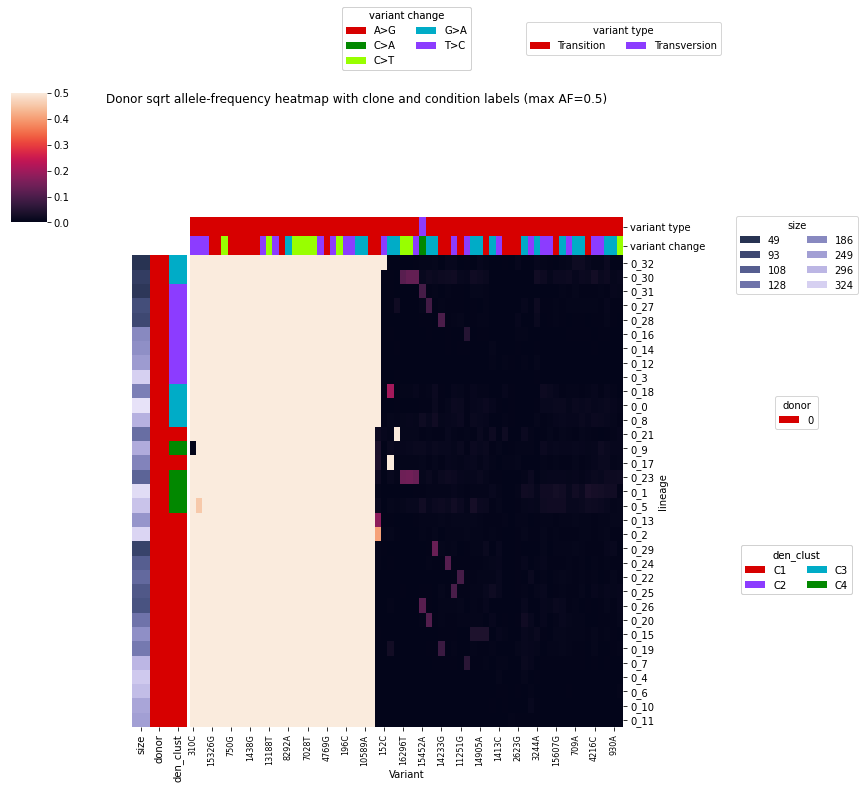

In [20]:
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
    g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
                        col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                        row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                        vmax=0.2, vmin=0, 
                        row_linkage=link)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=False)

    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                          row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                          col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                         )
    g1d.ax_cbar.set_title("log2(reads+1)")
    fu.helper_save(out_f+".dendro.NoCondition.DP.png")#, f=g1d.figure)


    mean_af = mean_af.iloc[inds,cols]
    curr_clones = curr_clones.loc[mean_af.index]

    ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                    col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                    row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                    vmax=0.5, vmin=0)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=False)

else:
    f = plt.figure()
    plt.title("no cells")
    f.savefig(out_f+".dendro.NoCondition.max2.AF.png")


In [21]:
out_f

'/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic/donor0'

### Save mean_af and curr_clonnes

In [22]:

mean_af.to_csv(out_f+".mean.csv")
curr_clones.to_csv(out_f+".clones_dendro.csv")